# Setting Up Environment

First we install Spark and the VADER sentiment analyzer which is used later on


In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install vaderSentiment
!pip install wordcloud

--2022-04-05 23:26:19--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  11.1MB/s    in 22s     

2022-04-05 23:26:42 (10.2 MB/s) - ‘spark-2.4.8-bin-hadoop2.7.tgz’ saved [235899716/235899716]

     |████████████████████████████████| 125 kB 4.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we set the environment path which enables you to run Pyspark in the Colab environment. In the following block we set the environment path and create a SparkSession

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("FinalProject").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

Let's load some useful packages 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import numpy as np
import tqdm

These are some flags used in the code to customize its running for testing purposes

In [ ]:
# If set to True uses SAMPLE_FRAC of the whole dataset 
SAMPLE = True
SAMPLE_FRAC = 0.5

# If set to True, a new model is trained else we load an 
# existing model
TRAIN = True

# Indicates the timeframe we group tweets by for our model
# eg. 'minute', 'hour', 'day'
TIMEFRAME = 'minute'

# Loading Dataset

Now let's load our Bitcoin Tweets dataset obtained from: https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets

Note that although the dataset itself is about 1GB, it can be considered big data because we can potentially use a much larger dataset containing more tweets from a more extensive time-frame 

Here I load the dataset from my Google Drive, the code will have to be edited to allow loading from other sources

In [ ]:
from pyspark.sql.types import StructField, StructType, StringType, BooleanType, DoubleType, TimestampType

# We know the structure of the data from the csv so by defining the schema manually, we can avoid the 
# extra pass over the data required when inferSchema=True in read.csv. 
# This helps make the solution more scalable as we don't have to make 2 passes over a potentially large dataset
manual_schema = StructType([StructField("user_name",StringType(),True),
                     StructField("user_location",StringType(),True),
                     StructField("user_description",StringType(),True),
                     StructField("user_created",StringType(),True),
                     StructField("user_followers",DoubleType(),True),
                     StructField("user_friends",DoubleType(),True),
                     StructField("user_favourites",DoubleType(),True),
                     StructField("user_verified",BooleanType(),True),
                     StructField("date",TimestampType(),True),
                     StructField("text",StringType(),True),
                     StructField("hashtags",StringType(),True),
                     StructField("source",StringType(),True),
                     StructField("is_retweet",BooleanType(),True)])

# Spark read.csv allows us to read the csv file into a Spark dataframe. 
# We use the parameters escape='"" and multiLine=True so that the csv is parsed cleanly
tweets = spark.read.csv("./drive/MyDrive/Colab Notebooks/Bitcoin_tweets.csv",inferSchema=False, header=True, escape='"', multiLine=True, schema=manual_schema, encoding='utf-8').cache()

if SAMPLE:
# Smaller sample for faster testing
  sample = round(tweets.count() * SAMPLE_FRAC)
  tweets = tweets.limit(sample)

tweets.show(5)

+--------------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+-------------------+----------+
|           user_name|  user_location|    user_description|       user_created|user_followers|user_friends|user_favourites|user_verified|               date|                text|            hashtags|             source|is_retweet|
+--------------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+-------------------+----------+
|       DeSota Wilson|    Atlanta, GA|Biz Consultant, r...|2009-04-26 20:05:09|        8534.0|      7605.0|         4838.0|        false|2021-02-10 23:59:04|Blue Ridge Bank s...|         ['bitcoin']|    Twitter Web App|     false|
|            CryptoND|           null|😎 BITCOINLIVE is...|2019-10-17 20:12:1

In [ ]:
# Verifying Columns and Datatypes
tweets.dtypes

[('user_name', 'string'),
 ('user_location', 'string'),
 ('user_description', 'string'),
 ('user_created', 'string'),
 ('user_followers', 'double'),
 ('user_friends', 'double'),
 ('user_favourites', 'double'),
 ('user_verified', 'boolean'),
 ('date', 'timestamp'),
 ('text', 'string'),
 ('hashtags', 'string'),
 ('source', 'string'),
 ('is_retweet', 'boolean')]

# Data Cleaning

For our analysis, let's drop columns that we are not going to use 

In [ ]:
tweets_clean = tweets.drop('user_name', 'user_description', 'user_created', 'user_location','user_verified', 'hashtags','source', 'is_retweet',)
tweets_clean.show(5)

+--------------+------------+---------------+-------------------+--------------------+
|user_followers|user_friends|user_favourites|               date|                text|
+--------------+------------+---------------+-------------------+--------------------+
|        8534.0|      7605.0|         4838.0|2021-02-10 23:59:04|Blue Ridge Bank s...|
|        6769.0|      1532.0|        25483.0|2021-02-10 23:58:48|😎 Today, that's ...|
|         128.0|       332.0|          924.0|2021-02-10 23:54:48|Guys evening, I h...|
|         625.0|       129.0|           14.0|2021-02-10 23:54:33|$BTC A big chance...|
|        1249.0|      1472.0|        10482.0|2021-02-10 23:54:06|This network is s...|
+--------------+------------+---------------+-------------------+--------------------+
only showing top 5 rows



Let's see how many null and Nan values we have in the dataset

In [ ]:
from pyspark.sql.functions import col,when,isnan,count

numeric_cols = ['user_friends', 'user_followers', 'user_favourites']
# Checking for null and ''
missing = tweets_clean.select([count(when(
                            (col(c) == '' ) | \
                            col(c).isNull(), c 
                           )).alias(c)
                    for c in tweets_clean.columns])
# Checking for nan
nan_count = tweets_clean.select([count(when(isnan(c), c)).alias(c) for c in numeric_cols])
missing.show()
nan_count.show()

+--------------+------------+---------------+----+----+
|user_followers|user_friends|user_favourites|date|text|
+--------------+------------+---------------+----+----+
|             6|           6|              6|   6|   6|
+--------------+------------+---------------+----+----+

+------------+--------------+---------------+
|user_friends|user_followers|user_favourites|
+------------+--------------+---------------+
|           0|             0|              0|
+------------+--------------+---------------+



Let's drop the rows with null values to make analysis easier

In [ ]:
tweets_clean = tweets_clean.na.drop()

# Run the code again to check for any null values 
numeric_cols = ['user_friends', 'user_followers', 'user_favourites']
# Checking for null and ''
missing = tweets_clean.select([count(when(
                            (col(c) == '' ) | \
                            col(c).isNull(), c 
                           )).alias(c)
                    for c in tweets_clean.columns])
# Checking for nan
nan_count = tweets_clean.select([count(when(isnan(c), c)).alias(c) for c in numeric_cols])
missing.show()
nan_count.show()

+--------------+------------+---------------+----+----+
|user_followers|user_friends|user_favourites|date|text|
+--------------+------------+---------------+----+----+
|             0|           0|              0|   0|   0|
+--------------+------------+---------------+----+----+

+------------+--------------+---------------+
|user_friends|user_followers|user_favourites|
+------------+--------------+---------------+
|           0|             0|              0|
+------------+--------------+---------------+



Let's clean up the `text` field by removing '#' and URL's

In [ ]:
from pyspark.sql.functions import UserDefinedFunction

def standardize_text(input):
  if isinstance(input, str):
    # remove newlines
    cleaned = re.sub('\\n','', input)
    # Make everything lowercase
    cleaned = cleaned.lower()
    # remove URLs
    cleaned = re.sub(r'http\S+', '', cleaned)
    # remove #
    cleaned = cleaned.replace('#', '')
    # remove &amp;
    cleaned = cleaned.replace('&amp','')
    return cleaned
  else:
    return ''

standardize_text_udf = UserDefinedFunction(standardize_text)

# Old text 
print("Below is the raw text:")
tweets.select('text').show(3,False)

# Cleaning text
tweets_clean = tweets_clean.withColumn('text', standardize_text_udf(tweets_clean.text))
print("Below is the cleaned text:")
tweets_clean.select('text').show(3,False)

Below is the raw text:
+----------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------+
|Blue Ridge Bank shares halted by NYSE after #bitcoin ATM announcement https://t.co/xaaZmaJKiV @MyBlueRidgeBank… https://t.co/sgBxMkP1SI       |
|😎 Today, that's this #Thursday, we will do a "🎬 Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expe… https://t.co/go6aDgRml5|
|Guys evening, I have read this article about BTC and would like to share with you all - https://t.co/QxCZgmuy3B… https://t.co/o6wn7ppkVY      |
+------------------------------------------------------------------------------------------------------------

# Data Exploration and Visualization

Here we will try to examine properties of the dataset that we are working with.
Firstly let's look at some summary statistics for numeric columns 

In [ ]:
tweets_clean.describe(['user_followers', 'user_friends', 'user_favourites']).show()

+-------+-----------------+------------------+------------------+
|summary|   user_followers|      user_friends|   user_favourites|
+-------+-----------------+------------------+------------------+
|  count|          1286509|           1286509|           1286509|
|   mean|9213.295383864395|1356.4350673022886|7218.1155017182155|
| stddev|120214.7382489366| 8720.902637210593|22762.639675552156|
|    min|              0.0|               0.0|               0.0|
|    max|      2.3597283E7|         4201104.0|         1248517.0|
+-------+-----------------+------------------+------------------+



Let's look at the most prevalent words in the `text` field of the dataset


In [ ]:
# Function defined to plot word clouds credit to https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# dat needs to be a dictionary of words and their frequencies 
def display_wordcloud(dat, title):
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 , 
        collocations=False
    ).generate_from_frequencies(dat)

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    fig.suptitle(title, fontsize=25)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()


For our function above, we need to create a dictionary of words and their frequencies which can be accomplished using Spark efficiently

In [ ]:
# STOPWORDS is a list of common words that we don't want in our word count 
# since we expect them to occur frequently. Let's add some more words to the set
stopwords = set(STOPWORDS)
stopwords.update(['see', 'us'])
# Select Text column of dataframe
text = tweets_clean.select('text')
# Change to an rdd of strings which represent the text from each row 
text_rdd = text.rdd.flatMap(lambda x : x)
# Flat map to get individual words
words_rdd = text_rdd.flatMap(lambda x : x.split())

# Mapping to get (word, 1) pairs
words_rdd = words_rdd.map(lambda x : (x, 1))

# Let's filter out 1 character words since they may not be useful 
# We also filter out stopwords 
# this also removes emojis which don't display well on word cloud
words_rdd = words_rdd.filter(lambda x : len(x[0]) > 1 and x[0] not in stopwords)

# Doing a word count by using reduceByKey
word_count = words_rdd.reduceByKey(lambda x, y : x + y)

# Sort and take top 100 words
word_count = dict(word_count.takeOrdered(100, lambda x : -x[1]))

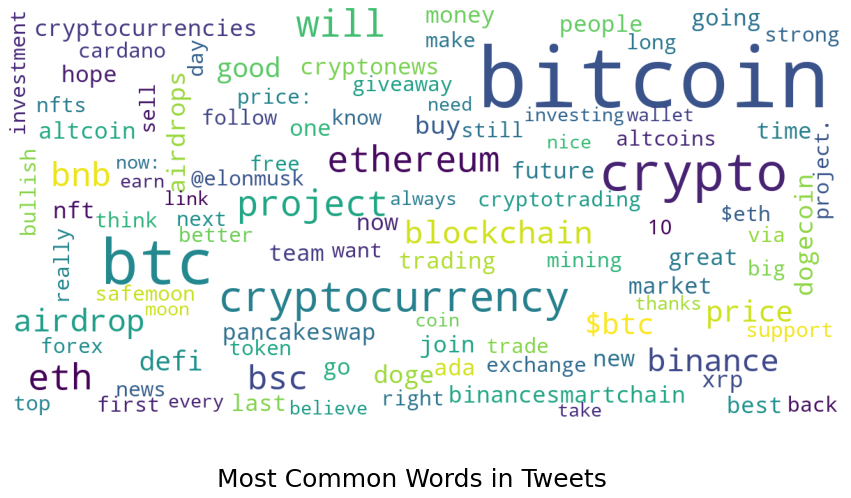

In [ ]:
# Plotting word cloud
display_wordcloud(word_count, "Most Common Words in Tweets")

# Sentiment Analysis

To conduct Sentiment Analysis we use the Valence Aware Dictionary and Sentiment Reasoner (VADER) which is a popular tool for sentiment analysis on social media posts since it is specifically tuned for this use case. For each tweet text, it assigns a `compound` score between -1 and 1. The closer the score is to -1, the more negative the sentiment and the closer to 1 it is, the more positive it is. 

In [ ]:
from numpy import double
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an instance of the analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# User defined function for getting polarity scores
polarity_score_udf = UserDefinedFunction(lambda x : sentiment_analyzer.polarity_scores(x)['compound'])

# Adding polarity scores to tweets in our df
tweets_clean = tweets_clean.withColumn('compound_score', polarity_score_udf(tweets_clean.text).cast('double'))

tweets_clean.show(3, False)

+--------------+------------+---------------+-------------------+-------------------------------------------------------------------------------------------------------------------+--------------+
|user_followers|user_friends|user_favourites|date               |text                                                                                                               |compound_score|
+--------------+------------+---------------+-------------------+-------------------------------------------------------------------------------------------------------------------+--------------+
|8534.0        |7605.0      |4838.0         |2021-02-10 23:59:04|blue ridge bank shares halted by nyse after bitcoin atm announcement  @myblueridgebank…                            |0.296         |
|6769.0        |1532.0      |25483.0        |2021-02-10 23:58:48|😎 today, that's this thursday, we will do a "🎬 take 2" with our friend @leowandersleb, btc wallet security expe… |0.8225        |
|128.0         |3

Let's make a bar graph to view the distribution of the compound scores in the tweets

In [ ]:
# Let's put the compound scores into buckets 
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0],inputCol="compound_score", outputCol="bucket")
compound_buckets = bucketizer.transform(tweets_clean)

compound_buckets.show(5)

# Select bucket cols and turn into rdd
bucket_rdd = compound_buckets.select("bucket").rdd
# Map to (bucket, 1) pairs for counting
bucket_rdd = bucket_rdd.map(lambda x : (x[0], 1))
# Count frequency of each bucket
bucket_count = bucket_rdd.reduceByKey(lambda x, y : x+y)
bucket_count = bucket_count.takeOrdered(10, lambda x : x[0])

+--------------+------------+---------------+-------------------+--------------------+--------------+------+
|user_followers|user_friends|user_favourites|               date|                text|compound_score|bucket|
+--------------+------------+---------------+-------------------+--------------------+--------------+------+
|        8534.0|      7605.0|         4838.0|2021-02-10 23:59:04|blue ridge bank s...|         0.296|   6.0|
|        6769.0|      1532.0|        25483.0|2021-02-10 23:58:48|😎 today, that's ...|        0.8225|   9.0|
|         128.0|       332.0|          924.0|2021-02-10 23:54:48|guys evening, i h...|        0.5719|   7.0|
|         625.0|       129.0|           14.0|2021-02-10 23:54:33|$btc a big chance...|        0.3164|   6.0|
|        1249.0|      1472.0|        10482.0|2021-02-10 23:54:06|this network is s...|        0.4019|   7.0|
+--------------+------------+---------------+-------------------+--------------------+--------------+------+
only showing top 5 r

Text(0.5, 1.0, 'Bar Chart Showing Compound Score Ranges and Frequencies')

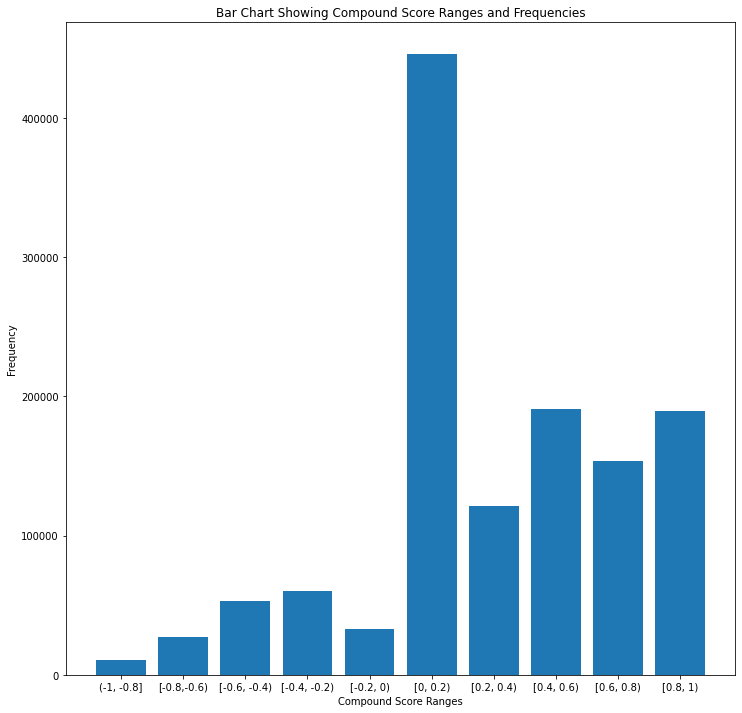

In [ ]:
# Plotting bar graph 
bucket = [round(x[0]) for x in bucket_count]
count = [x[1] for x in bucket_count]
plt.figure(figsize=(12,12))
ax = plt.subplot()
plt.bar(bucket, count)
plt.ylabel('Frequency')
plt.xlabel('Compound Score Ranges')
x_labels = ['(-1, -0.8]','[-0.8,-0.6)','[-0.6, -0.4)','[-0.4, -0.2)','[-0.2, 0)','[0, 0.2)','[0.2, 0.4)','[0.4, 0.6)','[0.6, 0.8)','[0.8, 1)']
ax.set_xticks(bucket)
ax.set_xticklabels(x_labels)
plt.title("Bar Chart Showing Compound Score Ranges and Frequencies")

From the above chart we can see most of the compound scores lie in the [0, 0.2) range so the majority of tweets are neutral to positive in sentiment.
We can take a closer look by using the following classification according to VADER:

*   positive sentiment : compound_score >= 0.05
*   negative sentiment : compound_score <= -0.05
*   neutral sentiment : compound_score > -0.05 and compound_score < 0.05





In [ ]:
# Categorizing sentiments

# First we get an rdd of all the compound scores
score_rdd = tweets_clean.select('compound_score').rdd.flatMap(lambda x : x)
score_rdd.take(2)

# Then we map the scores based on their values to a category
def categorize_sentiment(score):
  if score >= 0.05:
    return 'positive'
  elif score <= -0.05:
    return 'negative'
  else:
    return 'neutral'
category_rdd = score_rdd.map(lambda x : (categorize_sentiment(x), 1))
count_categories = category_rdd.reduceByKey(lambda x, y : x+y).collect()
print(count_categories)

[('positive', 689476), ('neutral', 415919), ('negative', 181114)]


Text(0.5, 1.0, 'Bar Chart Showing Sentiments and their Frequencies Among Tweets')

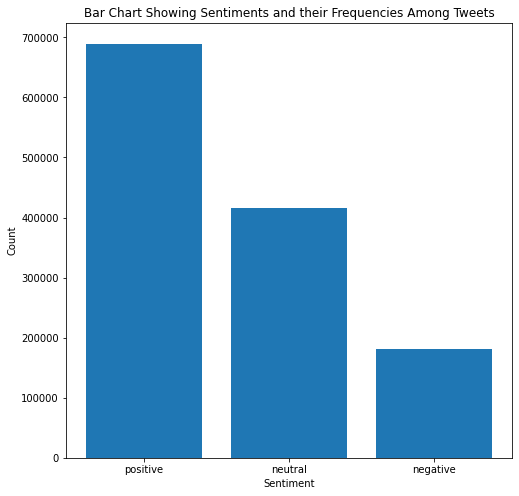

In [ ]:
# Let's plot this on a bar graph for visualization
categories = [x[0] for x in count_categories]
counts = [x[1] for x in count_categories]
plt.figure(figsize=(8,8))
plt.bar(categories, counts)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Bar Chart Showing Sentiments and their Frequencies Among Tweets')

# Price Data

Let's get the price data for Bitcoin for the same time period as our tweets using a dataset for minutely Bitcoin Data acquired from https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution?select=btcusd.csv

In [ ]:
# Since we know the structure of the dataset beforehand we define a manual schema
prices_schema = StructType([StructField("date",DoubleType(),True),
                     StructField("open",DoubleType(),True),
                     StructField("close",DoubleType(),True),
                     StructField("high",DoubleType(),True),
                     StructField("low",DoubleType(),True),
                     StructField("volume",DoubleType(),True)])

# Loading dataset from Google Drive
prices = spark.read.csv("./drive/MyDrive/Colab Notebooks/btcusd.csv",inferSchema=False, schema=prices_schema, header=True, encoding='utf-8').cache()
prices.show(5)

+-------------+-----+-----+-----+-----+-----------+
|         date| open|close| high|  low|     volume|
+-------------+-----+-----+-----+-----+-----------+
|1.36477482E12|93.25| 93.3| 93.3|93.25|       93.3|
|1.36477488E12|100.0|100.0|100.0|100.0|       93.3|
|1.36477494E12| 93.3| 93.3| 93.3| 93.3|33.67686227|
|1.36477506E12|93.35|93.47|93.47|93.35|       20.0|
|1.36477512E12|93.47|93.47|93.47|93.47| 2.02162704|
+-------------+-----+-----+-----+-----+-----------+
only showing top 5 rows



For our analysis we are only interested in the `time` column and the `close` column which represents the closing price for Bitcoin in USD at the end of each minute. Hence we drop all the other columns

In [ ]:
prices_clean = prices.drop("high","low","volume")
prices_clean.show(5)

+-------------+-----+-----+
|         date| open|close|
+-------------+-----+-----+
|1.36477482E12|93.25| 93.3|
|1.36477488E12|100.0|100.0|
|1.36477494E12| 93.3| 93.3|
|1.36477506E12|93.35|93.47|
|1.36477512E12|93.47|93.47|
+-------------+-----+-----+
only showing top 5 rows



Let's drop any missing values

In [ ]:
print("Rows before dropping missing values:", prices.count())
prices_clean = prices_clean.na.drop()
print("Rows after dropping missing values:",prices_clean.count())

Rows before dropping missing values: 3792275
Rows after dropping missing values: 3792275


Let's convert the time column which is in unix-timestamp to a readable timestamp format

In [ ]:
from pyspark.sql.functions import from_unixtime, to_timestamp
prices_clean = prices_clean.withColumn('date', to_timestamp(from_unixtime(col('date') / 1000)))
prices_clean.show(5)

+-------------------+-----+-----+
|               date| open|close|
+-------------------+-----+-----+
|2013-04-01 00:07:00|93.25| 93.3|
|2013-04-01 00:08:00|100.0|100.0|
|2013-04-01 00:09:00| 93.3| 93.3|
|2013-04-01 00:11:00|93.35|93.47|
|2013-04-01 00:12:00|93.47|93.47|
+-------------------+-----+-----+
only showing top 5 rows



# Merging Tweets Data and Price Data 

Let's make a new column for our analysis, `movement` which is 1 when the difference between the open price at minute T and the close price at minute T+1440 (ie, the next day) is positive or equal and 0 when it is negative (ie price decreased)

First we take our price dataset, shift the days by 1 backward, then select only the rows that are within the range of our tweet dates. This introduces a lag of 1 day. 

In [ ]:
from pyspark.sql.functions import asc, unix_timestamp

prices_clean_lag = prices_clean.withColumn('date', from_unixtime(unix_timestamp(col('date')) - 86400)).drop('open')
# Rename columns for joining
prices_clean_lag = prices_clean_lag.withColumnRenamed('close', 'close_nextday')
prices_clean_lag.show(5)

+-------------------+-------------+
|               date|close_nextday|
+-------------------+-------------+
|2013-03-31 00:07:00|         93.3|
|2013-03-31 00:08:00|        100.0|
|2013-03-31 00:09:00|         93.3|
|2013-03-31 00:11:00|        93.47|
|2013-03-31 00:12:00|        93.47|
+-------------------+-------------+
only showing top 5 rows



In [ ]:
# Now inner join the original price_clean with the price_clean_lag
# This means for every row we have the current price and the price 1 day ahead
prices_clean = prices_clean_lag.join(prices_clean.drop('close'), on='date', how='inner')
prices_clean.show(5)

+-------------------+-------------+------------------+
|               date|close_nextday|              open|
+-------------------+-------------+------------------+
|2013-04-03 11:59:00|       137.06|             139.1|
|2013-04-04 14:28:00|        137.0|             135.0|
|2013-04-07 16:54:00|      186.921|153.54399999999995|
|2013-04-08 20:05:00|       232.99|           190.026|
|2013-04-09 19:58:00|        160.0|             231.5|
+-------------------+-------------+------------------+
only showing top 5 rows



Now let's calculate the `movement` column which will act as our label. We also make a column `diff` which shows the difference in the open price and close price on the next day for correlation calculations later on

In [ ]:
# Adding movement column
prices_clean = prices_clean.withColumn('movement', (col('close_nextday')-col('open') >= 0).cast("float"))
# Adding diff column
prices_clean = prices_clean.withColumn('diff', col('close_nextday')-col('open'))
prices_clean.show(5)

+-------------------+-------------+------------------+--------+------------------+
|               date|close_nextday|              open|movement|              diff|
+-------------------+-------------+------------------+--------+------------------+
|2013-04-03 11:59:00|       137.06|             139.1|     0.0|-2.039999999999992|
|2013-04-04 14:28:00|        137.0|             135.0|     1.0|               2.0|
|2013-04-07 16:54:00|      186.921|153.54399999999995|     1.0| 33.37700000000004|
|2013-04-08 20:05:00|       232.99|           190.026|     1.0|            42.964|
|2013-04-09 19:58:00|        160.0|             231.5|     0.0|             -71.5|
+-------------------+-------------+------------------+--------+------------------+
only showing top 5 rows



Before proceeding let's drop columns from our tweets and prices dataframe that we are not going to use for machine learning

In [ ]:
tweets_clean = tweets_clean.drop('user_followers','user_friends', 'user_favourites', 'text')
prices_clean = prices_clean.drop('open', 'close_nextday')

Now we need to aggregate our tweets according to a timeframe and find the average `compound_score` over that timeframe. The timeframe to use is specified by the flag TIMEFRAME.
First we truncate tweets to the nearest day/minute etc depending on the timeframe

In [ ]:
from pyspark.sql.functions import date_trunc
print("Before truncating date:")
tweets_clean.select("date").show(5)
tweets_clean = tweets_clean.withColumn("date", date_trunc(TIMEFRAME, col("date")))
print("After truncating date:")
tweets_clean.select("date").show(5)

Before truncating date:
+-------------------+
|               date|
+-------------------+
|2021-02-10 23:59:04|
|2021-02-10 23:58:48|
|2021-02-10 23:54:48|
|2021-02-10 23:54:33|
|2021-02-10 23:54:06|
+-------------------+
only showing top 5 rows

After truncating date:
+-------------------+
|               date|
+-------------------+
|2021-02-10 23:59:00|
|2021-02-10 23:58:00|
|2021-02-10 23:54:00|
|2021-02-10 23:54:00|
|2021-02-10 23:54:00|
+-------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

w = Window.partitionBy('date')
tweets_clean = tweets_clean.withColumn("avg_score", F.avg("compound_score").over(w))
# Selecting columns we are interested in only
tweets_clean = tweets_clean.select("date", "avg_score").dropDuplicates()

Let's order our tweets dataframe and our prices dataframe in ascending order of date

In [ ]:
# Sorting tweets by date in ascending order
tweets_clean = tweets_clean.orderBy(col("date"))
tweets_clean.show(5)

# Sorting prices by date in ascending order
prices_clean = prices_clean.orderBy(col("date"))
prices_clean.show(5)

+-------------------+-------------------+
|               date|          avg_score|
+-------------------+-------------------+
|2021-02-05 10:52:00|            0.04962|
|2021-02-05 10:53:00|             0.6249|
|2021-02-05 10:54:00|             0.2732|
|2021-02-05 10:57:00|             0.7783|
|2021-02-05 10:58:00|0.41913333333333336|
+-------------------+-------------------+
only showing top 5 rows

+-------------------+--------+------------------+
|               date|movement|              diff|
+-------------------+--------+------------------+
|2013-04-01 00:12:00|     1.0|          10.52001|
|2013-04-01 01:00:00|     1.0| 9.519999999999996|
|2013-04-01 01:11:00|     1.0|10.199990000000014|
|2013-04-01 01:28:00|     1.0| 9.529990000000012|
|2013-04-01 02:38:00|     1.0| 10.50988000000001|
+-------------------+--------+------------------+
only showing top 5 rows



Now let's get the prices for the time periods that correspond with our tweets dataset

In [ ]:
# For max/min for tweets dataset
max_date_tweets = tweets_clean.agg({"date":"max"})
max_date_tweets = max_date_tweets.collect()[0]["max(date)"]
print("Latest date in our tweets dataset is:", max_date_tweets)
min_date_tweets = tweets_clean.agg({"date":"min"})
min_date_tweets = min_date_tweets.collect()[0]["min(date)"]
print("Earliest date in our tweets dataset is:", min_date_tweets)

# For max/min for prices dataset
max_date_prices = prices_clean.agg({"date":"max"})
max_date_prices = max_date_prices.collect()[0]["max(date)"]
print("Latest date in our prices dataset is:", max_date_prices)
min_date_prices = prices_clean.agg({"date":"min"})
min_date_prices = min_date_prices.collect()[0]["min(date)"]
print("Earliest date in our prices dataset is:", min_date_prices)

Latest date in our tweets dataset is: 2021-10-19 23:59:00
Earliest date in our tweets dataset is: 2021-02-05 10:52:00
Latest date in our prices dataset is: 2022-03-26 10:34:00
Earliest date in our prices dataset is: 2013-04-01 00:12:00


Let's join the tweets dataframe and the prices dataframe together using `date` as the join key

In [ ]:
# Getting prices date range to be the same as tweets date range
prices_clean = prices_clean.filter(col("date").between(min_date_tweets,max_date_tweets))

full_data = tweets_clean.join(prices_clean, on='date', how='inner')
full_data.show(5)

+-------------------+-------------------+--------+------+
|               date|          avg_score|movement|  diff|
+-------------------+-------------------+--------+------+
|2021-02-05 13:02:00| 0.6971333333333334|     1.0|2132.0|
|2021-02-05 17:10:00|                0.0|     1.0|2722.0|
|2021-02-06 03:02:00|              0.296|     0.0|-768.0|
|2021-02-06 04:16:00|0.19733333333333333|     0.0|-239.0|
|2021-02-06 09:24:00| 0.4969666666666666|     0.0|-345.0|
+-------------------+-------------------+--------+------+
only showing top 5 rows



Let's compute the correlation between the `avg_score` and `diff` columns. We check the Pearson correlation which gives an idea of the strength of the linear relationship between the variables. The value lies between -1 and 1 where -1 indicates a strong negative linear relationship and 1 indicates a strong positive linear relationship. 

In [ ]:
from pyspark.mllib.stat import Statistics

# Pearson Correlation Coefficient to check for a linear relationship
pearson_corr = full_data.stat.corr("avg_score", "diff")
print("The Pearson correlation coefficient is: ", pearson_corr)

The Pearson correlation coefficient is:  4.859898825529738e-05


# Predicting Price Change based on Tweet Sentiment with Random Forest Regression

We will create split the data using 60% for training, 20% for validation and 20% for final testing. Since our data is time series data we must use the earliest data in terms of `date` for the training date and the latest data for testing. Random splits cannot be used 

In [ ]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window

ranked_data = full_data.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date")))
train_data = ranked_data.where("rank <= 0.6").drop("rank")
valid_data = ranked_data.where("rank > 0.6 AND rank <= 0.8").drop("rank")
test_data = ranked_data.where("rank > 0.8 AND rank <= 1").drop("rank")

Let's fit a Random Forest Model. First we change our features into Vectors so it can be input into our library models

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# combining features into a single vector for use in model
assembler = VectorAssembler(inputCols=['avg_score'], outputCol="features")
test_data = assembler.transform(test_data)
if TRAIN:
  valid_data = assembler.transform(valid_data)
  train_data = assembler.transform(train_data)

Now let's define a few Random Forest Models with different parameters and fit the data to it. This a more manual approach to hyperparameter tuning since we don't want to randomize our dataset since it is a time-series and many built in functions for hyperparameter tuning randomize the dataset. This block is only executed if `TRAIN=True`. Else we just load an existing model 

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel

if TRAIN:
  # Defining our model -  let's define 3 different models with different hyperparams
  rf_regs = [RandomForestRegressor(labelCol='diff', maxDepth=5, maxBins=32, numTrees=10), \
            RandomForestRegressor(labelCol='diff', maxDepth=5, maxBins=32, numTrees=20), \
            RandomForestRegressor(labelCol='diff', maxDepth=10, maxBins=32, numTrees=10),
            RandomForestRegressor(labelCol='diff', maxDepth=5, maxBins=32, numTrees=15)]
  model_regs = []
  for rf in rf_regs:
    model_regs.append(rf.fit(train_data))
print("Regression Models Fitted!")

Regression Models Fitted!


Now we evaluate our models on the validation data to find the best one. Since this is a regression model we use Mean Squared Error and Root Mean Squared Error as metrics.

In [ ]:
if TRAIN:
  # Getting predictions from valiidation data
  predictions = []
  for model in model_regs:
    predictions.append(model.transform(valid_data))

  # Calculating metrics 
  target_and_pred = []
  for pred in predictions:
    target_and_pred.append(pred.select('diff', 'prediction').rdd.map(lambda x : (x[0], x[1])))

  valid_MSE = []
  for tp in target_and_pred:
    valid_MSE.append(tp.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() / float(valid_data.count()))
  valid_RMSE = [np.sqrt(x) for x in valid_MSE]

  for i in range(0, len(valid_MSE)):
    print('Model', i, 'Validation MSE =', valid_MSE[i])
    print('Model', i, 'Validation RMSE =', valid_RMSE[i])

Model 0 Validation MSE = 3240859.5218822
Model 0 Validation RMSE = 1800.2387402459153
Model 1 Validation MSE = 3241268.7777590095
Model 1 Validation RMSE = 1800.352403769609
Model 2 Validation MSE = 3242623.5710233483
Model 2 Validation RMSE = 1800.7286222591533
Model 3 Validation MSE = 3243069.5448432425
Model 3 Validation RMSE = 1800.8524494925293


If `TRAIN=True` we find the best model and save it. Else we load the existing

In [ ]:
if TRAIN:
  # Find index for model with lowest RMSE
  best_model_idx = np.argmin(valid_RMSE)
  # Save that model
  model_regs[best_model_idx].write().overwrite().save('./rf_model_reg')

# Loading our model 
best_model = RandomForestRegressionModel.load('./rf_model_reg')

Let's use our best model to make predictions 

In [ ]:
predictions = best_model.transform(test_data)

Let's evaluate Test MSE and RMSE

In [ ]:
target_and_pred = predictions.select('diff', 'prediction').rdd.map(lambda x : (x[0], x[1]))
# test_MSE = target_and_pred.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() / float(test_data.count())
# test_RMSE = np.sqrt(test_MSE)
# print('Test Set MSE =', test_MSE)
# print('Test Set RMSE =', test_RMSE)

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
reg_metrics = RegressionMetrics(target_and_pred)
print('Test Set MSE =', reg_metrics.meanSquaredError)
print('Test Set RMSE =', reg_metrics.rootMeanSquaredError)

Test Set MSE = 2008793.2258293473
Test Set RMSE = 1417.3190275408524


In the cells below we make a plot of the price changes and our predicted price changes against the date

In [ ]:
# Plot for visualization 
plot_points = predictions.select('date','diff','prediction').rdd.take(sample)
date = [x[0] for x in plot_points]
diff = [x[1] for x in plot_points]
prediction = [x[2] for x in plot_points]


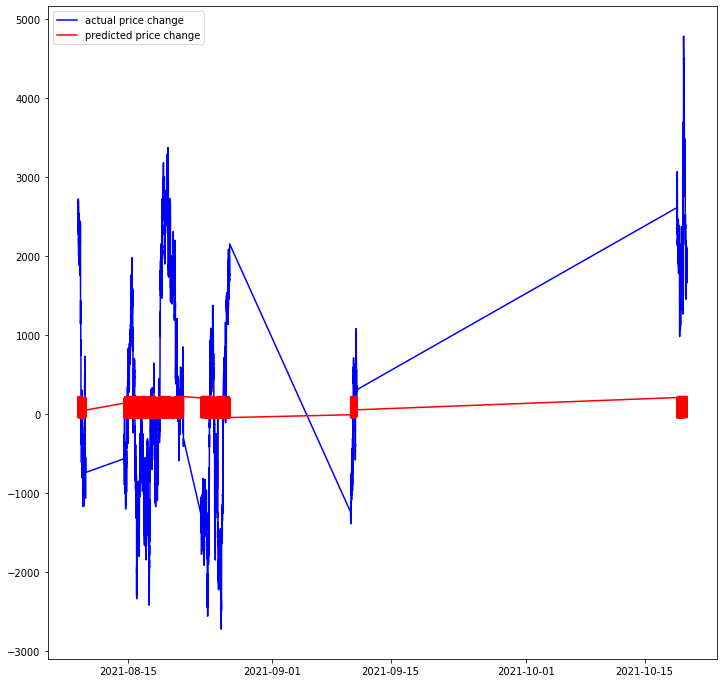

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(date, diff, color='blue', label='actual price change')
plt.plot(date, prediction, color='red', label='predicted price change')
plt.legend()

# Predicting Price Movement Direction with Random Forest Classifier

Let's try to fit a Classification model using Random Forest Classifier. This will predict whether the price will move up or down given the tweet sentiments. That is given `avg_score` it attempts to predict `movement`

Similar to before, we will try fitting different models with different hyperparameters and choose the best one based on performance on our validation set

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.mllib.evaluation import MulticlassMetrics


if TRAIN:
  # Defining our model -  let's define 3 different models with different hyperparams
  rf_class = [RandomForestClassifier(labelCol='movement', maxDepth=5, maxBins=32, numTrees=10), \
            RandomForestClassifier(labelCol='movement', maxDepth=5, maxBins=32, numTrees=20), \
            RandomForestClassifier(labelCol='movement', maxDepth=10, maxBins=32, numTrees=10),
            RandomForestClassifier(labelCol='movement', maxDepth=5, maxBins=32, numTrees=15)]
  model_class = []
  for rf in rf_class:
    model_class.append(rf.fit(train_data))
print("Classification Models Fitted!")

Classification Models Fitted!


Now we evaluate our models on the validation data to find the best one. Since this is a classification model we use accuracy as the metric

In [ ]:
if TRAIN:
  # Getting predictions from valiidation data
  predictions = []
  for model in model_class:
    predictions.append(model.transform(valid_data))

  # Calculating metrics 
  target_and_pred = []
  for pred in predictions:
    target_and_pred.append(pred.select('movement', 'prediction').rdd.map(lambda x : (x[0], x[1])))

  accuracy_scores = []
  for tp in target_and_pred:
    metrics = MulticlassMetrics(tp)
    accuracy_scores.append(metrics.accuracy)

  for i in range(0, len(valid_MSE)):
    print('Model', i, 'Accuracy =', accuracy_scores[i])

Model 0 Accuracy = 0.6459512349923309
Model 1 Accuracy = 0.6168614798751785
Model 2 Accuracy = 0.6459512349923309
Model 3 Accuracy = 0.589622890992754


If `TRAIN=True` we find the best model and save it. Else we load the existing

In [ ]:
if TRAIN:
  # Find index for model with highest accuracy
  best_model_idx = np.argmax(accuracy_scores)
  # Save that model
  model_class[best_model_idx].write().overwrite().save('./rf_model_class')

# Loading our model 
best_model = RandomForestClassificationModel.load('./rf_model_class')

Let's use our best model to make predictions on the test dataset

In [ ]:
predictions = best_model.transform(test_data)
target_and_pred =predictions.select('movement', 'prediction').rdd.map(lambda x : (x[0], x[1]))
metrics = MulticlassMetrics(target_and_pred)


Let's see the accuracy of our model on the test set 

In [ ]:
print('Test Set Accuracy =', metrics.accuracy)

Test Set Accuracy = 0.5707108102390522


Let's visualize some metrics to see how well the model performs

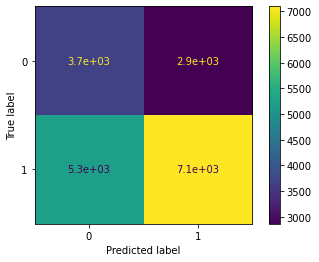

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
# Plotting Confusion Matrix
cm = metrics.confusionMatrix().toArray()
# y labels
ls = [0, 1] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot()
plt.show()

Let's look at a ROC curve. In general, an area under the ROC curve can be interpreted as follows:
*   0.5 : no discrimination - poor performance
*   0.7 to 0.8 : acceptable performance
*   0.8 to 0.9 : excellent performance
*   \> 0.9 : outstanding performance

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

bin_metrics = BinaryClassificationMetrics(target_and_pred)
print('Area under ROC curve', bin_metrics.areaUnderROC)
print('Recall', metrics.weightedRecall)
print('Precision', metrics.weightedPrecision)

Area under ROC curve 0.5689686793519798
Recall 0.5707108102390522
Precision 0.6085652205805469
